# tf_data 이용하여 이미지 데이터셋과 배치 만들어 모델링

In [1]:
import os 
from glob import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

###  이미지 파일 하나 읽어 이미지 보기

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'cifar',
 'cifar.zip',
 'dog1.jfif',
 'mnist_png',
 'mnist_png.zip',
 'tensorflow flow_from_dataframe 이용하여 이미지 읽고 모델만들기.ipynb',
 'tensorflow flow_from_directory 이용하여 이미지 읽고 모델만들기.ipynb',
 'test_dataset.csv',
 'tf_data 이용하여 이미지 데이터셋과 배치 만들어 모델링.ipynb',
 'train_dataset.csv',
 'Untitled.ipynb',
 '[해설]09.tensorflow 2.0 - 05.flow_from_dataframe_dataframe_적용하여_학습_시키기.ipynb',
 '[해설]10~11.tensorflow 2.0 - 06~07.tf_data_load_image___make_batch.ipynb',
 '[해설]13~14.tensorflow 2.0 - 09~10.callbacks_tensorboard.ipynb',
 '[해설]15.tensorflow 2.0 - 11.callbacks_learning_rate_schedule.ipynb',
 '[해설]17.tensorflow 2.0 - 13.post_process_history_(결과_확인).ipynb',
 '[해설]18.tensorflow 2.0 - 14.post_process_predict___predict_generator.ipynb',
 '[해설]19.tensorflow 2.0 - 15.save_and_load_model_h5.ipynb',
 '데이터셋 만들때 같이 활용 12. callbacks - learning rate schedule.ipynb']

In [3]:
path = './cifar/cifar/train/0_frog.png'

In [4]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)

In [5]:
image.shape

TensorShape([32, 32, 3])

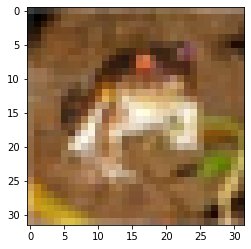

In [6]:
plt.imshow(image)
plt.show()

# tf.data

In [7]:
train_paths = glob('./cifar/cifar/train/*.png')
train_paths[:10]

['./cifar/cifar/train\\0_frog.png',
 './cifar/cifar/train\\10000_automobile.png',
 './cifar/cifar/train\\10001_frog.png',
 './cifar/cifar/train\\10002_frog.png',
 './cifar/cifar/train\\10003_ship.png',
 './cifar/cifar/train\\10004_ship.png',
 './cifar/cifar/train\\10005_cat.png',
 './cifar/cifar/train\\10006_deer.png',
 './cifar/cifar/train\\10007_frog.png',
 './cifar/cifar/train\\10008_airplane.png']

In [8]:
# 이미지 이름 주면 이미지 읽어 반환
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image

In [9]:
# map 변환 병렬화
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [10]:
# 이미지 읽어올 패스 지정(from_tensor_slices)하고 해당 패스에서 map 함수를 통해 이미지 읽어오기
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)

In [11]:
# 데이터셋에서 1개 이미지 가져오기
tf_image = next(iter(dataset))
tf_image.shape

TensorShape([32, 32, 3])

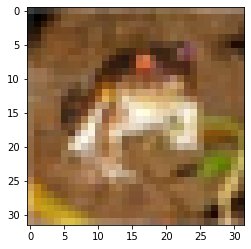

In [12]:
plt.imshow(tf_image)
plt.show()

## Batch로 묶기

In [13]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(4)

In [14]:
tf_images = next(iter(dataset))
tf_images.shape

TensorShape([4, 32, 32, 3])

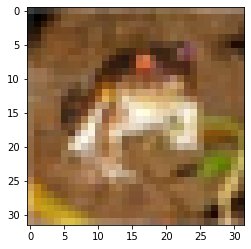

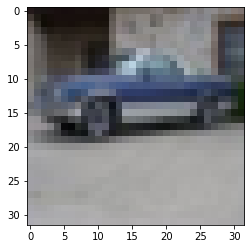

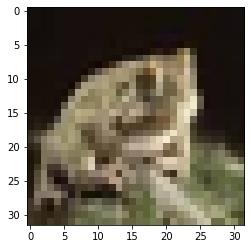

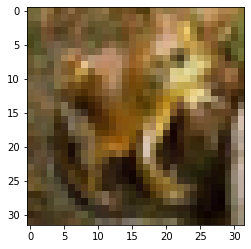

In [15]:
for i in range(4):
    plt.imshow(tf_images[i])
    plt.show()

## Shuffle 하기

In [16]:
len(train_paths)

50000

In [17]:
# repeat 안주면 1 epoch에서 끝나게 되므로 여러 epoch할 경우 repeat 주어야 함.
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.repeat()

In [18]:
# shuffle 시간 좀 걸림
tf_images = next(iter(dataset))
tf_images.shape

TensorShape([4, 32, 32, 3])

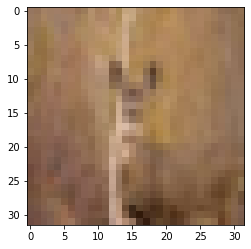

In [19]:
# shuffle 이전에 첫번째 이미지가 개구리 이미지이었는데, 지금은 다른 이미지로 shuffle 되것 확인
plt.imshow(tf_images[0])
plt.show()

## 데이터셋 만들때 이미지와 Label하고 같이 넣기 

In [20]:
path = train_paths[0]
path

'./cifar/cifar/train\\0_frog.png'

In [21]:
os.path.basename(path).replace('.png', '').split('_')[-1]

'frog'

In [22]:
def get_label(path):
    return os.path.basename(path).replace('.png', '').split('_')[-1]

In [23]:
path, get_label(path)

('./cifar/cifar/train\\0_frog.png', 'frog')

In [24]:
train_labels = [get_label(path) for path in train_paths]
train_labels[:5]

['frog', 'automobile', 'frog', 'frog', 'ship']

In [25]:
class_names = np.unique(train_labels)
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [26]:
'frog' == class_names

array([False, False, False, False, False, False,  True, False, False,
       False])

In [27]:
onehot_encoding = np.array('frog' == class_names, np.uint8)
onehot_encoding

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [28]:
def onehot_encoding(label):
    return np.array(label == class_names, np.uint8)

In [29]:
def load_data(path, label):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image, label

In [30]:
train_labels[:5]

['frog', 'automobile', 'frog', 'frog', 'ship']

In [31]:
labels = [onehot_encoding(cls_name) for cls_name in train_labels]
labels[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [32]:
# 이미지패스와 이미지 같이 입력
dataset = tf.data.Dataset.from_tensor_slices((train_paths, labels))
dataset = dataset.map(load_data, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.repeat()

In [33]:
image, label = next(iter(dataset))

In [34]:
np.array(label[0])

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

D:\Anaconda3\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


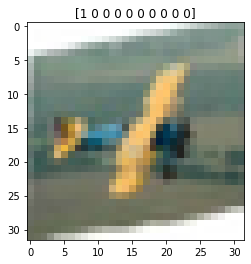

In [35]:
plt.title(np.array(label[0]))
plt.imshow(image[0])
plt.show()

## 이미지 정보를 가지고 이미지와 label 한번에 얻기(tensorflow 함수로 label 얻기)

In [36]:
path

'./cifar/cifar/train\\0_frog.png'

In [37]:
fname = tf.strings.split(path, '_')[-1]
lbl_name = tf.strings.regex_replace(fname, '.png', '')
lbl_name

<tf.Tensor: shape=(), dtype=string, numpy=b'frog'>

In [38]:
onehot = tf.cast(lbl_name == class_names, tf.uint8)
onehot

<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)>

In [39]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return onehot

In [40]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    label = get_label(path)
    return image, label

In [41]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.repeat()

In [42]:
image, label = next(iter(dataset))

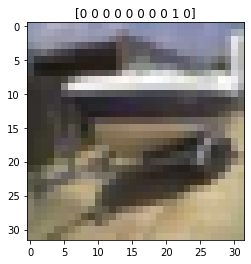

In [43]:
plt.title(np.array(label[0]))
plt.imshow(image[0])
plt.show()

# @ tf.data 이용 및 위의 내용 정리하고 모델링

## 라이브러리 import

In [53]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%matplotlib inline

## Hyperparameter Tunning

In [54]:
num_epochs = 20
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

# Data Preprocess

In [55]:
train_paths = glob('./cifar/cifar/train/*.png')[:1000]
test_paths = glob('./cifar/cifar/test/*.png')[:1000]

In [56]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [57]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [58]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [59]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [60]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [61]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [63]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Build Model

In [64]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [65]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

## Learning Rate Scheduler

In [66]:
import math

In [67]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * math.exp(0.1 * (10 - epoch))

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Training

In [68]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[learning_rate_scheduler]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
31/31 [==============================] - 4s 130ms/step - loss: 2.3175 - accuracy: 0.0950 - val_loss: 2.2995 - val_accuracy: 0.0897
Epoch 2/20
31/31 [==============================] - 4s 131ms/step - loss: 2.2650 - accuracy: 0.1333 - val_loss: 2.2076 - val_accuracy: 0.1331
Epoch 3/20
31/31 [==============================] - 4s 127ms/step - loss: 2.2251 - accuracy: 0.1818 - val_loss: 2.1254 - val_accuracy: 0.2188
Epoch 4/20
31/31 [==============================] - 4s 129ms/step - loss: 2.1767 - accuracy: 0.1986 - val_loss: 2.0636 - val_accuracy: 0.2450
Epoch 5/20
31/31 [==============================] - 4s 124ms/step - loss: 2.0849 - accuracy: 0.2108 - val_loss: 2.0302 - val_accuracy: 0.2470
Epoch 6/20
31/31 [==============================] - 4s 128ms/step - loss: 2.0268 - accuracy: 0.2345 - val_loss: 1.9551 - val_accuracy: 0.2762
Epoch 7/20
31/31 [==============================] - 4s 126ms/step - loss

## history

In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

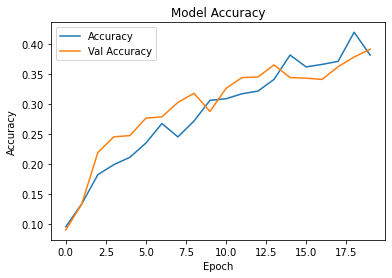

In [70]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

## Predict

### 1. 이미지를 Load 직접 load해서 넣는 방법

In [71]:
path = train_paths[0]
test_image, test_label = load_image_label(path)

In [72]:
test_image.shape

TensorShape([32, 32, 3])

In [73]:
test_image = test_image[tf.newaxis, ...]
test_image.shape

TensorShape([1, 32, 32, 3])

In [74]:
pred = model.predict(test_image)

In [75]:
pred

array([[2.7170775e-03, 9.1465545e-04, 7.1512766e-02, 6.2065173e-02,
        2.1455957e-01, 3.2244574e-02, 5.5691373e-01, 5.7834737e-02,
        5.0627353e-04, 7.3136610e-04]], dtype=float32)

In [76]:
np.argmax(pred)

6

### 2. generator에서 데이터를 가져오는 방법

In [77]:
test_image, test_label = next(iter(test_dataset))

In [78]:
test_image.shape

TensorShape([32, 32, 32, 3])

In [79]:
pred = model.predict(test_image)
pred.shape

(32, 10)

In [80]:
pred[0]

array([0.03960688, 0.02605383, 0.07142237, 0.14973837, 0.11191718,
       0.15625551, 0.1465627 , 0.2277655 , 0.0178517 , 0.05282588],
      dtype=float32)

In [81]:
np.argmax(pred, axis=1)

array([7, 5, 0, 6, 2, 0, 1, 1, 8, 9, 6, 4, 0, 0, 7, 9, 5, 6, 1, 6, 0, 2,
       3, 1, 7, 0, 8, 3, 7, 4, 0, 3], dtype=int64)

### 3.generator에 넣는 방법

In [82]:
pred = model.predict_generator(test_dataset.take(1))

Instructions for updating:
Please use Model.predict, which supports generators.


In [83]:
pred.shape

(32, 10)

In [84]:
pred = model.predict_generator(test_dataset.take(2))
pred.shape

(64, 10)

In [85]:
np.argmax(pred, axis=1)

array([7, 5, 0, 6, 2, 0, 1, 1, 8, 9, 6, 4, 0, 0, 7, 9, 5, 6, 1, 6, 0, 2,
       3, 1, 7, 0, 8, 3, 7, 4, 0, 3, 6, 6, 7, 8, 6, 3, 4, 6, 6, 9, 3, 4,
       6, 5, 6, 7, 2, 0, 6, 4, 0, 1, 1, 1, 1, 7, 8, 5, 9, 5, 6, 7],
      dtype=int64)